# Lab 6 - The learning pipeline

So far we added one little bit at a time to our weaponry of machine learning knowledge and tools. We started from simple, one-dimensional datasets which we fitted using very simple models implemented by us (and it worked!). Then we added some complexity by generating datasets from polynomials, which required more complex models. That in turns raised the question: which is the right level of complexity to choose? So we introduced model selection, and the idea of evaluating a model by splitting the dataset into _training_ and _test_ set. Then we started experimenting on datasets which had more than one or two dimensions, and introduced _variable selection_ to cope with this problem.

I think now is a good time to step back and regain some perspective.

The following image shows the various steps of a typical learning pipeline.

![Supervised learning pipeline](supervised_learning_pipeline.png)

Starting from the dataset, we split it into training and test set, then proceed by _training_ a model using **exclusively** the training set. We then use this model to predict the outputs relative to the inputs in the _test set_ and compare our predictions to the _actual_ outputs (we are in a supervised learning, so we _do_ have them) in order to have an estimante of how our model would perform when used on future data.

In this section we will explore the concept of *selection bias* as described in [[1]](http://members.cbio.mines-paristech.fr/~jvert/svn/bibli/local/Ambroise2002Selection.pdf) and [[2]](ftp://ftp.disi.unige.it/person/MosciS/PAPERS/esann.pdf) using a *filter method* for variable selection.

Main concepts:

 * Learning pipeline
 * Unbiased feature selection
 * Experimental design
 * Selection bias
 
 
The main question we're going to answer: **how should an experiment be designed in order to produce reliable, unbiased results?**

## Imports and setup

The usual stuff:

 * Magic command `%matplotlib inline` so that plots are displayed correctly in the notebook.
 * `matplotlib` followed by `seaborn` in order to have fancy plots
 * `numpy` _et similia_ for number crunching.
 
Additional libraries will be imported whenever they are needed

In [1]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from __future__ import division

import seaborn

import numpy as np

from scipy import stats

## Dataset generation

Let's first create two `X`, `y` datasets for binary classification with `n=50` samples and `d=1000` **dummy** variables each. We will use the first for training and the second for test. We don't use `make_classification` as we did before because this time we want to see what happens when we analyze datasets made of random noise only.

<img style="float: left;" src="warning.png" width="20px"> &nbsp; **Pay attention here**:  Look closely at how the dataset is generated. We just extract random $n$ $d$-valued vectors from the _standard normal distribution_ and assigning to half of them a label and to the other one another label, but again, samples from these two "classes" actually come from the same population. In such dataset there should be no hope of performing any kind of classification with accuracy better than chance $= 50\%$.


In [2]:
# Mean and standard deviation for N (dummy variables)
mu = 0.0
sigma = 1.0

alpha=0.05

# Number of samples
half_n = 25

# Number of variables
d = 1000

np.random.seed(2)

# Training dataset
X_tr = mu+sigma*np.random.randn(2*half_n, d)
y_tr = np.ones(2*half_n)
y_tr[:half_n] = 0

# Test dataset
X_ts = mu+sigma*np.random.randn(2*half_n, d)
y_ts = np.ones(2*half_n)
y_ts[:half_n] = 0


Using only the training set, let's now sort the variables according to their p-value obtained by means of a T test.

<img style="float: left;" src="info.png" width="20px"> &nbsp; **Info**: If you don't know what is a T test or a p-value, let me give you the short version: a T test is a statistical test which is used to determine if two distributions are equal (sort of). It returns a p-value, which is confronted with a fixed threshold (usually set to 0.05 or 0.01): if it is lower than that threshold, the two distributions are declared to be different. It can be used for variable selection by confronting, for each individual variable, the distributions of values for _that_ variable for samples of the two classes.


In [3]:
p_values = np.array([stats.ttest_ind(X_tr[half_n:,j], X_tr[:half_n,j])[1] for j in range(d)])
sorted_variables = np.argsort(p_values)

Let's see how many variables would be selected by a _T test_. We'll try it with and without the Bonferroni correction.

In [4]:
# Without Bonferroni correction
selected_variables = np.where(p_values[sorted_variables] < alpha)[0]
print("[No Bonferroni] - {} variables pass the T-test".format(len(selected_variables)))

# With Bonferroni correction
B_selected_variables = np.where(p_values[sorted_variables] < alpha/d)[0]
print("[With Bonferroni] - {} variables pass the T-test".format(len(B_selected_variables)))

[No Bonferroni] - 48 variables pass the T-test
[With Bonferroni] - 0 variables pass the T-test


Let's now select the top $k$ variables with $k$ in $[1, \dots, 200]$. For each $k$ we will estimate the <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation")>5-Fold cross-validation</a> accuracy of a linear classifier.

In [5]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=5)
clf = RidgeClassifier(alpha=0)
accuracies = []
k_values = np.arange(1, 200, 10)

for k in k_values:
    selected = sorted_variables[:k]
    
    # KFCV
    acc_kf = []
    for train_index, vld_index in kf.split(X_tr):
        clf.fit(X_tr[train_index][:,selected], y_tr[train_index])  # fit model on the training set
        y_pred = clf.predict(X_tr[vld_index][:,selected])  # predict test set
        acc_kf.append(accuracy_score(y_tr[vld_index], y_pred))  # estimate accuracy
    
    # Save the KFCV mean accuracy for k
    accuracies.append(np.mean(acc_kf))
accuracies = np.array(accuracies)

Plot the KF accuracy against the number of selected variables.

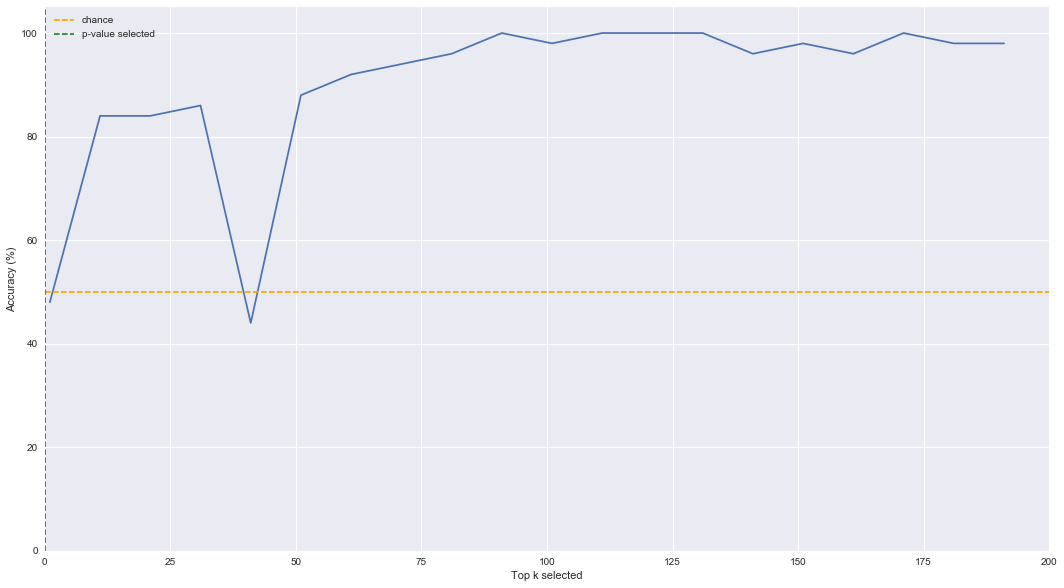

In [6]:
fig, ax1 = plt.subplots(figsize=(18, 10))

ax1.plot(k_values, accuracies*100)
ax1.axhline(50.0, ls='--', c='orange', label='chance')
# plt.axhline(0.5, ls='--', c='orange', label='chance')
ax1.axvline(len(B_selected_variables), ls='--',
            label='p-value selected', c='forestgreen')
ax1.set_xlim([0,200])
ax1.set_ylim([0,105])
ax1.set_xlabel('Top k selected')
ax1.set_ylabel('Accuracy (%)')
ax1.legend();

Even if only few variables (maybe even 0) pass the T-test, it looks like selecting more variables increases the accuracy of the model. But is that a real effect?

In order to verify it, choose the number of variables that gives best prediction accuracy. Then fit a linear classifier on the training set and try to predict the test set. This allows you to estimate the **out-of-sample** prediction accuracy. **<font color='red'>What do you expect?</font>**

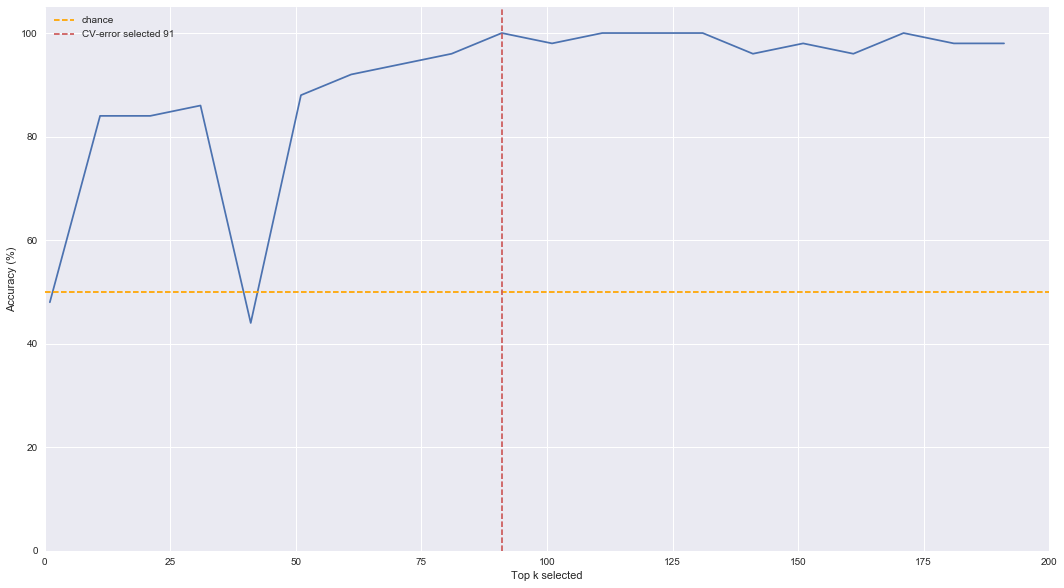

In [7]:
# Choose the number of selected variables that maximize the prediction accuracy
CV_error_selected = k_values[np.argmax(accuracies)]

fig, ax1 = plt.subplots(figsize=(18, 10))
ax1.plot(k_values, accuracies*100)
ax1.axhline(50.0, ls='--', c='orange', label='chance')
# ax1.axvline(len(B_selected_variables), ls='--',
#             label='p-value selected {}'.format(len(B_selected_variables)), c='forestgreen')
ax1.axvline(CV_error_selected, ls='--',
            label='CV-error selected {}'.format(CV_error_selected), c='indianred')

ax1.set_xlim([0,200])
ax1.set_ylim([0,105])
ax1.set_xlabel('Top k selected')
ax1.set_ylabel('Accuracy (%)')
ax1.legend();

In [8]:
# Restrict the data matrix to the first CV_error_selected variables
X_tr_small = X_tr[:, sorted_variables[:CV_error_selected]]

# Fit a linear classifier on the training set
clf.fit(X_tr_small, y_tr)

# Predict the test set and measure the prediction accuracy
y_pred = clf.predict(X_ts[:, sorted_variables[:CV_error_selected]])
print('Out-of-samples prediction accuracy: {}%'.format(100*accuracy_score(y_ts, y_pred)))

Out-of-samples prediction accuracy: 46.0%
